In [2]:
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from osprey.config import Config

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Get Trial Databases

In [49]:
df = pd.read_pickle('/Users/robert_arbon/Google Drive/Research/Hyperparameter_Optimisation/Code/DHFR/rerun_results/best_trials_50foldCV.pickl')

In [55]:
df2 = pd.read_pickle('original_scores.pickl')

In [58]:
df = df.merge(df2, on=['id', 'strategy', 'feature'], how='left')

In [66]:
df.drop(labels=['test_scores_error', 'test_scores_mean'], axis=1, inplace=True)

## Calculate mean score 


In [75]:
from sklearn.utils import resample
def safe_mean(x):
    try:
        return np.array(x).mean()
    except TypeError:
        return np.nan

def safe_error(x):
    try:
        n = int(1e4)
        alpha = 0.95
        x_bs = resample(x, n_samples=n)
        x_bs = np.sort(x_bs)
        low_ci = x_bs[int(n*(1 - alpha)/2.0)]
        high_ci = x_bs[int(n*(alpha+((1-alpha)/2.0)))]
        err = high_ci - low_ci
#         err = np.array(x).std()
        return err
    except TypeError:
        return np.nan


In [76]:
# Note - this assumes that the folds are all the same size.  This is fine for DHFR as all trajectories are 1000 ns long. 

observables = ['new_test_scores', 'test_scores']

for observable in observables:
        df[observable+'_error'] = df.loc[:, observable].apply(safe_error)
        df[observable+'_mean'] = df.loc[:, observable].apply(safe_mean)

In [77]:
df.head()

,id,new_test_scores,strategy,feature,cluster__n_clusters,tica__n_components,tica__lag_time,variance_cut__threshold,rank,test_scores,new_test_scores_error,new_test_scores_mean,test_scores_error,test_scores_mean
0,1323,"[1.98519071086, 3.9519083114, 1.9934532403, 3....",csp,psi_tor,34,10,114,0.000360,1.0,"[2.996102284491902, 15.458372140484464, 16.074...",14.468069,5.387008,14.088715,8.292813
1,2719,"[1.96742943059, 1.95292769502, 1.9226300305, 2...",csp,psi_tor,266,9,20,0.000110,2.0,"[1.9810396588927515, 1.9904764710095006, 16.63...",3.025559,2.631180,14.655410,6.623258
2,2671,"[1.99620709244, 1.98796333511, 2.97977813852, ...",csp,psi_tor,25,9,27,0.003339,3.0,"[3.8031027220702187, 8.741692942689902, 1.9546...",7.858591,3.985416,7.465641,6.549576
3,565,"[6.10722712176, 1.92893847972, 1.94598949834, ...",csp,omega_tor,488,6,488,0.000193,4.0,"[6.89120843825471, 7.165872795707341, 1.942201...",5.472197,3.279790,6.710437,6.149266
4,372,"[2.7644710845, 1.91356540749, 3.67625886651, 3...",csp,omega_tor,87,10,368,0.002071,5.0,"[9.364271296265807, 2.858972815986415, 1.85131...",6.866356,3.589891,7.512955,6.126570


In [78]:
error = pd.melt(df, id_vars = ['id', 'strategy', 'feature'], 
                value_vars = ['test_scores_error', 'new_test_scores_error'], 
               value_name = 'error')
error['variable'] = error['variable'].apply(lambda x: 'new' if x.split('_')[0]=='new' else 'old')
mean = pd.melt(df, id_vars = ['id', 'strategy', 'feature'], 
               value_vars = ['test_scores_mean', 'new_test_scores_mean'], 
              value_name = 'mean')
mean['variable'] = mean['variable'].apply(lambda x: 'new' if x.split('_')[0]=='new' else 'old')

In [79]:
mean

,id,strategy,feature,variable,mean
0,1323,csp,psi_tor,old,8.292813
1,2719,csp,psi_tor,old,6.623258
2,2671,csp,psi_tor,old,6.549576
3,565,csp,omega_tor,old,6.149266
4,372,csp,omega_tor,old,6.126570
5,2527,csp,psi-o_tor,old,5.889998
6,238,csp,omega_tor,old,5.850801
7,1160,csp,psi_tor,old,5.750096
8,53,csp,omega_tor,old,5.690354
9,135,csp,psi-o_tor,old,5.614148


In [80]:
df2 = mean.merge(right=error, on=['id', 'strategy', 'feature', 'variable'], how='inner')

In [81]:
df2.head()

,id,strategy,feature,variable,mean,error
0,1323,csp,psi_tor,old,8.292813,14.088715
1,2719,csp,psi_tor,old,6.623258,14.655410
2,2671,csp,psi_tor,old,6.549576,7.465641
3,565,csp,omega_tor,old,6.149266,6.710437
4,372,csp,omega_tor,old,6.126570,7.512955


## Plot difference

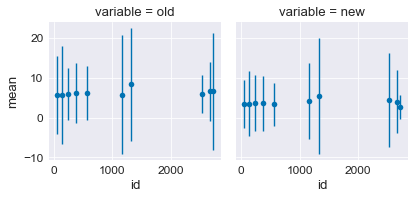

In [82]:
with sns.plotting_context('paper', font_scale=1.5):
    sns.set_palette('colorblind')
    g = sns.FacetGrid(df2, col='variable', sharey='row')
    g = g.map(plt.errorbar,'id',  'mean', 'error', fmt='o', alpha=1)
    